In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import numpy as np
from keras import Model

'''
X(Extreme)Inception - Strongly implements inception hypothesis - > Cross channel and spatial correlations can be in effect decoupled
Inception module == first look at cross channel correlations(1x1 kernel) map into sep small spaces then use 3x3/5x5 kernels to map them into 3d space
____Depthwise seperable convolution operation_____
Unlike inception xception first perform spatial depthwise conv followed by pt wise conv op
'''

In [ ]:
def conv_fn(inputs, kernel_size, filters, strides=1, relu=None, pool=None):
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
             padding='same')(inputs)
  x = BatchNormalization()(x)

  if relu:
    return ReLU()(x)
  if pool:
    return MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)

  return x

In [ ]:
def sconv_fn(inputs, kernel_size, filters, strides=1, relu=None, pool=None):
  x = SeparableConv2D(filters=filters, kernel_size=kernel_size, strides=strides,
             padding='same')(inputs)
  x = BatchNormalization()(x)

  if relu:
    return ReLU()(x)
  if pool:
    return MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)

  return x

In [ ]:
def make_entry_flow(x):
  x = conv_fn(x, 3, 32, strides=2, relu=True)
  x = conv_fn(x, 3, 64, relu=1)

  x_branch = conv_fn(x, 1, 128, strides=2)

  x = sconv_fn(x, 3, 128, relu=1)
  x = sconv_fn(x, 3, 128, pool=1)

  x = Add()([x, x_branch])
  x = ReLU()(x)
  x = sconv_fn(x, 3, 256, relu=1)
  x = sconv_fn(x, 3, 256, pool=1)

  x_branch = conv_fn(x_branch,1,256, strides=2)

  x = Add()([x, x_branch])
  x = ReLU()(x)
  x = sconv_fn(x, 3, 728, relu=1)
  x = sconv_fn(x, 3, 728, pool=1)

  x_branch = conv_fn(x_branch,1,728, strides=2)

  midput = Add()([x_branch, x])

  return midput

In [ ]:
def make_middle_flow(midput):
    for _ in range(8):
        x = ReLU()(midput)
        x = sconv_fn(x, filters=728, kernel_size=3, relu=1)
        x = sconv_fn(x, filters=728, kernel_size=3, relu=1)
        x = sconv_fn(x, filters=728, kernel_size=3)

        output = Add()([midput, x])

    return output

In [ ]:
def make_exit_flow(output):

    x = ReLU()(output)
    x = sconv_fn(x, filters=728, kernel_size=3, relu=1)
    x = sconv_fn(x, filters=1024, kernel_size=3, pool=1)


    output = conv_fn(output, filters=1024, kernel_size=1, strides=2)

    x = Add()([output, x])
    x = sconv_fn(x, filters=1536, kernel_size=3, relu=1)
    x = sconv_fn(x, filters=2048, kernel_size=3, relu=1)
    x = GlobalAvgPool2D()(x)
    x = Dense(units=1000, activation='softmax')(x)

    return x

In [ ]:

input = Input(shape=[299, 299, 3])

x = make_entry_flow(input)
y = make_middle_flow(x)
output = make_exit_flow(y)


model = Model(input, output)

In [ ]:
model_entry = Model(input, make_entry_flow(input))
model_middle = Model(x, make_middle_flow(x))
model_exit = Model(y, make_exit_flow(y))

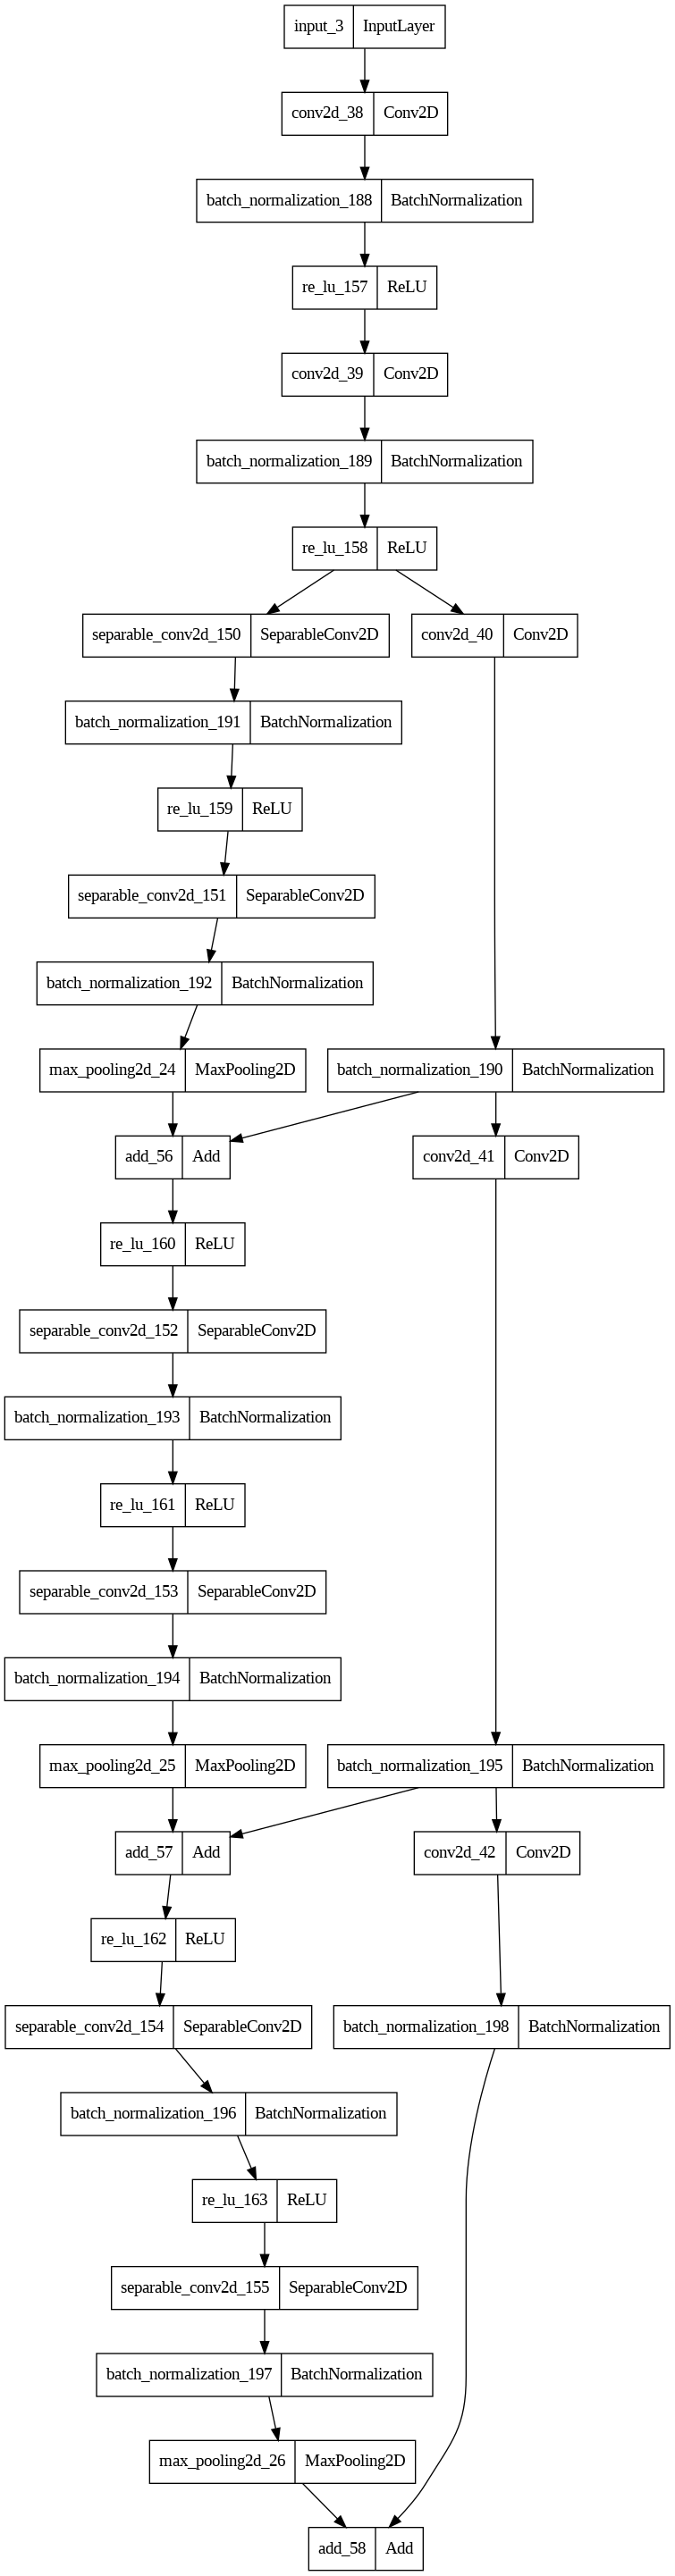

In [ ]:
keras.utils.plot_model(model_entry)

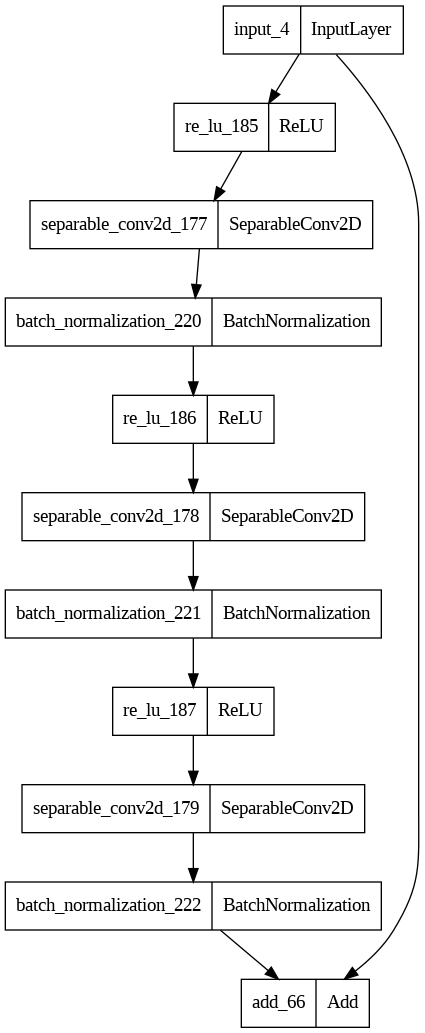

In [ ]:
keras.utils.plot_model(model_middle)

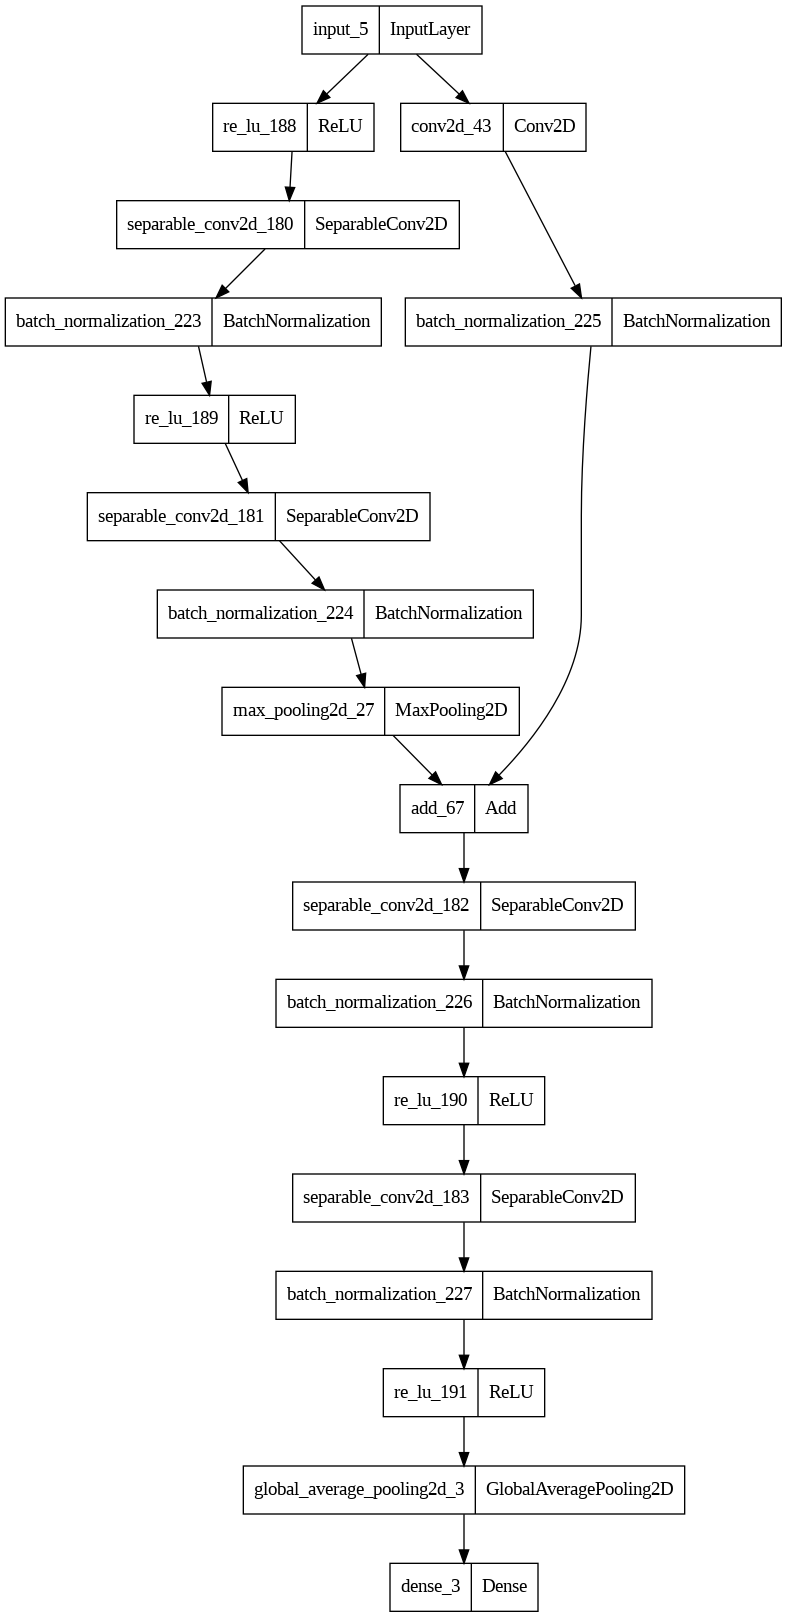

In [ ]:
keras.utils.plot_model(model_exit)

In [ ]:
def return_xception_model():
  from keras import Model
  input = Input(shape=(299,299,3))
  ins = make_entry_flow(input)
  mids = make_middle_flow(ins)
  output = make_exit_flow(mids)

  return Model(input, output)

In [ ]:
model = return_xception_model()

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_50 (Conv2D)          (None, 150, 150, 32)         896       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_268 (B  (None, 150, 150, 32)         128       ['conv2d_50[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 re_lu_227 (ReLU)            (None, 150, 150, 32)         0         ['batch_normalization_2

Architecture from paper implementation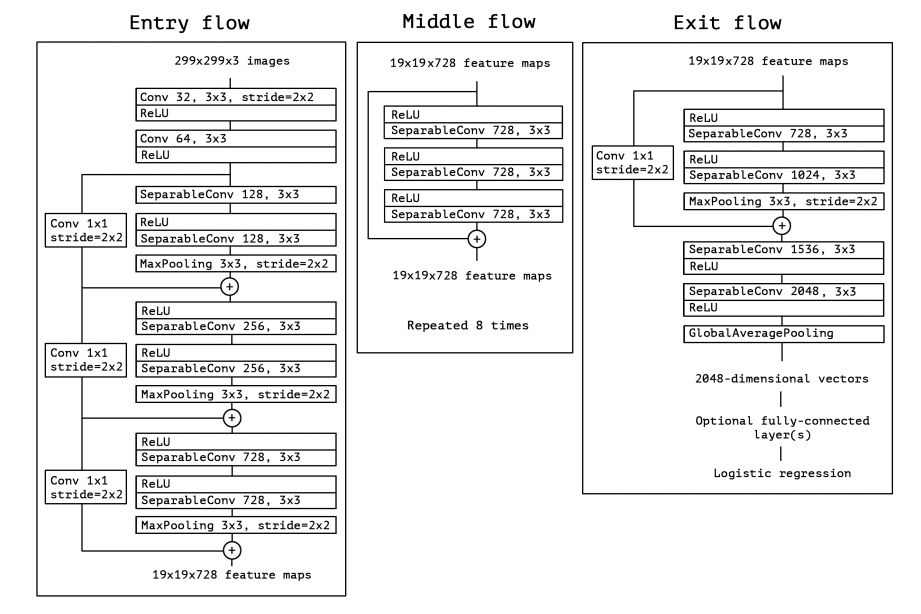